## Solving a complex solidification problem using an efficient methodology of physics-informed AI

In [ ]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math as m
from time import time
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [ ]:
# check availability of gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# to load files from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Constants

$C_0 = 0.05$</br>
$m_l = -81.1$</br>
$m_s = -478$</br>
$c_p = 820$</br>
$ρ = 7000$</br>
$L_f = 276000$</br>
$T_f = 1538$</br>
$T_∞ = 1540$</br>
$T_0 = 1510$</br>
$k_0 = 0.17$</br>
$Le = 300$</br>

$Ste = c_p(T_∞-T_0)/L_f$</br>
$θ_f = (T_f-T_0)/(T_∞-T_0)$</br>

Transcendental Equation to determine $\phi$ from constants</br>
5 Equations for analytical solutions parameterised in $\phi$

###Conditions

Domain $\epsilon \in [0,ϵ^*]$</br>
$C_s = k_0C_l^*$ (constant)</br>
PDE1: $\frac{∂\theta_s}{∂\tau} = \frac{∂^2\theta_s}{∂\epsilon^2}$</br>
Domain $\epsilon \in [ϵ^*,1]$</br>
PDE2: $\frac{∂\theta_l}{∂\tau} = \frac{∂^2\theta_l}{∂\epsilon^2}$</br>
PDE3: $\frac{∂C_l}{∂\tau} = \frac{1}{Le}\frac{∂^2C_l}{∂\epsilon^2}$</br>
Interface ($ϵ=ϵ^*$)</br>
PDE4: $\frac{1}{Ste}\frac{∂\epsilon^*}{∂\tau} = \frac{∂\theta_s}{∂\epsilon}-\frac{∂\theta_l}{∂\epsilon}$</br>
PDE5: $\frac{-1}{Le}\frac{∂C_l}{∂ϵ}=C_l^*(1-k_0)\frac{dϵ^*}{dτ}$</br>

5 PDEs with 5 Variables [$θ_s(x,t)$, $θ_l(x,t)$, $C_s(x,t)$, $C_l(x,t)$, $ϵ^*(t)$]</br>
Model the 5 variables using 4 neural networks and optimise the NN parameters</br>

Initial ($\tau = 0$)</br>
$θ_l=1$ ; $C_l=C_0$ ; $ϵ^*=0$</br>
Interface ($ϵ=ϵ^*$)</br>
$θ_s=θ_l=θ^*$</br>
$C_l^* = (T_0-T_∞)(θ_f-θ^*)/m_l$</br>
Left BC ($ϵ=0$)</br>
$θ_s=0$

In [ ]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float

a = tf.constant(1., dtype=DTYPE)
C0, Le, cp, Ti, T0, Tf, Lf, ml, k0, phi = 0.05*a, 300*a, 820*a, 1540*a, 1510*a, 1538*a, 276000*a, -81.1*a, 0.17*a, 0.1159*a
Ste = cp*(Ti-T0)/Lf
uf = (Tf-T0)/(Ti-T0)
pie = tf.constant(m.pi, dtype=DTYPE)
ustar = tf.math.erf(phi)*(1+(tf.math.erfc(phi)*tf.math.exp(phi**2)*phi*(pie**0.5)/Ste)) # actual temp coeff at interface

In [ ]:
def C_(u_): # concentration of liquid at interface (Cl*) given interface temp
  return (T0-Ti)*(uf-u_)/ml
Clstar = C_(ustar)
Cs = k0*Clstar
Clstar, Cs

(<tf.Tensor: shape=(), dtype=float32, numpy=0.19923599>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.03387012>)

###Evaluating PDEs

In [ ]:
def f1(u1_t, u1_xx): # calculates PDE1 value given u1's derivatives
  return u1_t - u1_xx

def f2(u2_t, u2_xx): # calculates PDE2 value given u2's derivatives
  return u2_t - u2_xx

def f3(c_t, c_xx): # calculates PDE3 value given c's derivatives
  return c_t - (c_xx/Le)

def f4(s_t, u1_x, u2_x): # calculates PDE4 value
  return (s_t/Ste) - u1_x + u2_x

def f5(c_x, cstar, s_t): # calculates PDE5 value
  return (cstar*(1-k0)*s_t)+(c_x/Le)

###Analytical Solutions

In [ ]:
def u1_anal(t,x): # calculates u1 value from its analytical solution
  return ustar*tf.math.erf(x/(2*(t**0.5)))/tf.math.erf(phi)

def u2_anal(t,x): # calculates u2 value from its analytical solution
  return 1-((1-ustar)*tf.math.erfc(x/(2*(t**0.5)))/tf.math.erfc(phi))

c1_anal = k0*C_(ustar) # analytical value of Cs

def c2_anal(t,x): # calculates c2 value from its analytical solution
  return C0 + ((C_(ustar)-C0)*tf.math.erfc((x*(Le**0.5))/(2*(t**0.5)))/tf.math.erfc(phi*(Le**0.5)))

def s_anal(t): # calculates s value from its analytical solution
  return 2*phi*(t**0.5)

def u_anal(t,x): # analytical value of u given x and t
  return tf.where(tf.math.greater(s_anal(t),x),u1_anal(t,x),u2_anal(t,x))

def c_anal(t,x): # analytical value of c given x and t
  return tf.where(tf.math.greater(s_anal(t),x),c1_anal,c2_anal(t,x))

###Training Data

In [ ]:
Nm1, Nm2 = 900, 50 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm1 = tf.random.uniform((Nm1,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
tm2 = tf.random.uniform((Nm2,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
im = tf.zeros(shape=(Nm2,1), dtype=DTYPE)
tm = tf.concat([tm1,tm2,im],axis=0)
xm1 = tf.random.uniform((Nm1,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
sm = s_anal(tm2)
xm2 = tf.random.uniform((Nm2,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
xm = tf.concat([xm1,sm,xm2],axis=0)
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points
sm2 = s_anal(tm)

###Modelling Variables

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def c_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for Cl
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

###Compute gradients to return PDE values

In [ ]:
def get_f(umodel, smodel, c2model, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = umodel(tf.concat([t, x], axis=1)) # u1 and u2 as functions of t and x
    u1, u2 = u[:, 0:1], u[:, 1:2]
    c2 = c2model(tf.concat([t, x], axis=1)) # c2 as a function of t and x
    s = smodel(t)
    tape.watch(s)
    ub = umodel(tf.concat([t, s], axis=1))
    u1b, u2b = ub[:, 0:1], ub[:, 1:2]
    cb = c2model(tf.concat([t, s], axis=1))
    # defined within context to compute 2nd derivatives
    u1_x = tape.gradient(u1, x)
    u2_x = tape.gradient(u2, x)
    c_x = tape.gradient(c2, x)
  u1b_x = tape.gradient(u1b, s)
  u2b_x = tape.gradient(u2b, s)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  u1_t = tape.gradient(u1, t)
  u2_t = tape.gradient(u2, t)
  u1_xx = tape.gradient(u1_x, x)
  u2_xx = tape.gradient(u2_x, x)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f1(u1_t, u1_xx), f2(u2_t, u2_xx), f3(c_t, c_xx), f4(s_t, u1b_x, u2b_x), f5(cb_x, cb, s_t)

###Calculating loss

In [ ]:
def loss_fxn(umodel, smodel, c1, c2model, mea, um, cm, xc, times, e): # compute loss given model and data

    pum = umodel(mea) # Temperature prediction on measurement data
    pu1m, pu2m = pum[:, 0:1], pum[:, 1:2]
    pc2m = c2model(mea) # Liquid concentration prediction on measurement data
    pc1m = tf.ones_like(pc2m, dtype=DTYPE)*c1
    psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
    pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
    pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
    Lm1 = tf.reduce_mean(tf.square(um - pum))
    Lm2 = tf.reduce_mean(tf.square(cm - pcm))
    Lm3 = tf.reduce_mean(tf.square(sm2 - psm))
    Lm = (Lm1 + Lm2 + Lm3)*25.6

    init = tf.constant(0,shape=(1,1),dtype=DTYPE)
    ti = tf.zeros(shape=xc.shape, dtype=DTYPE)
    init2 = tf.concat([ti, xc], axis=1)
    pu2i = umodel(init2)[:, 1:2] # predicted initial temp of liquid
    pc2i = c2model(init2) # predicted initial conc of liquid
    Li1 = tf.squeeze(tf.square(smodel(init)))
    Li2 = tf.reduce_mean(tf.square(pc2i-C0))
    Li3 = tf.reduce_mean(tf.square(pu2i-a))
    Li = Li1*25600 + Li2*100 + Li3*100

    tot_loss = Lm + Li
    sum_loss = tf.zeros(shape=(), dtype=DTYPE)
    error = Lm1+Lm2+Lm3+Li1+Li2+Li3

    for t in times:

      ts = tf.reshape(t,(1,1))
      psb = smodel(ts) # Predicted Interface position
      pub = umodel(tf.concat([ts, psb], axis=1)) # Interface Temperature prediction
      pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
      pcb = c2model(tf.concat([ts, psb], axis=1)) # Liquid Interface Concentration prediction
      pu0b = umodel(tf.concat([ts, init], axis=1))[:, 0:1] # Left boundary temperature prediction
      Lb1 = tf.reduce_mean(tf.square(pu0b))
      Lb2 = tf.reduce_mean(tf.square(pu1b-pu2b))
      Lb3 = tf.reduce_mean(tf.square(pcb-C_(pu1b)))
      Ls = tf.reduce_mean(tf.square(c1-(k0*pcb))) # relation bwn Cs and Cl*
      Lb = (Lb1 + Lb2 + Lb3 + Ls)*256

      tc = tf.ones_like(xc, dtype=DTYPE)*t
      coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
      f_1, f_2, f_3, f_4, f_5 = get_f(umodel, smodel, c2model, coll) # calculate f values given models and collocation data
      Lc1 = tf.reduce_mean(tf.square(f_1))
      Lc2 = tf.reduce_mean(tf.square(f_2))
      Lc3 = tf.reduce_mean(tf.square(f_3))
      Lc4 = tf.reduce_mean(tf.square(f_4))
      Lc5 = tf.reduce_mean(tf.square(f_5))
      Lc = Lc1 + Lc2 + Lc3 + Lc4 + Lc5

      w = tf.math.exp(-e*sum_loss)
      tot_loss += w*(Lc+Lb)/Nt
      sum_loss += (Lc+Lb)
      error += (Lb1+Lb2+Lb3+Ls+Lc)/Nt

    return tot_loss, error

###Computing Loss Gradients

In [ ]:
def L_and_grad_Lw(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    loss, error = loss_fxn(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e) # loss as a function of model (& hence weights)
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc2 = tape.gradient(loss, cmodel.trainable_variables)
  if abs(c1-Cs)>0.0001:
    gc1 = tape.gradient(loss, c1)
  else:
    gc1 = 0.0
  del tape
  return loss, error, gu, gs, gc2, gc1

In [ ]:
Nt, Nx = 100, 256 # No of t and x points sampled
c1 = tf.Variable(0.2, dtype=DTYPE) # initialise solid conc
umodel = u_model() # initialise the Temp NN model
smodel = s_model() # initialise the Intf NN model
cmodel = c_model() # initialise the Conc NN model
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)

In [ ]:
@tf.function

def train_step(xc, times, e):

  # compute loss and its gradient wrt model parameters
  loss, error, gu, gs, gc2, gc1 = L_and_grad_Lw(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e)

  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  optim.apply_gradients(zip(gs, smodel.trainable_variables))
  optim.apply_gradients(zip(gc2, cmodel.trainable_variables))
  #if abs(tf.reduce_mean(smodel(times)-s_anal(times)))>0.001:
        #optim.apply_gradients(zip(gs, smodel.trainable_variables))
  if abs(c1-Cs)>0.0001:
        optim.apply_gradients([(gc1, c1)])

  return loss, error

### Causal Training 1

In [ ]:
uweights = []
sweights = []
cweights = []
c1vals = []

N = 200 # no of epochs or training iterations
losses = []
errors = []
t0 = time()
epsilons = [0.01,0.1,1,10,100]

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        l, e = train_step(xc, times, e)
        loss = l.numpy()
        error = e.numpy()
        losses.append(loss)
        errors.append(error)
        uweights.append(umodel.get_weights())
        sweights.append(smodel.get_weights())
        cweights.append(cmodel.get_weights())
        c1vals.append(c1)
        if i%5==0:
            print('   Epoch = '+str(i)+' --> Loss = '+str(loss)+' and Error = '+str(error))

print('Computation Time = {} minutes'.format((time()-t0)/60))

Looping for epsilon = 0.01 ...


   Epoch = 5 --> Loss = 53.474827 and Error = 1.9501103
   Epoch = 10 --> Loss = 10.32569 and Error = 2.7650158
   Epoch = 15 --> Loss = 2.9691243 and Error = 1.6580251
   Epoch = 20 --> Loss = 4.7738595 and Error = 0.7872792
   Epoch = 25 --> Loss = 2.0141444 and Error = 1.7049823
   Epoch = 30 --> Loss = 2.2237918 and Error = 0.656904
   Epoch = 35 --> Loss = 1.0981268 and Error = 1.4570016
   Epoch = 40 --> Loss = 1.125597 and Error = 0.9654963
   Epoch = 45 --> Loss = 1.0903108 and Error = 1.8109049
   Epoch = 50 --> Loss = 0.81971157 and Error = 1.0916834
   Epoch = 55 --> Loss = 0.6607279 and Error = 1.3193743
   Epoch = 60 --> Loss = 0.5895293 and Error = 1.241481
   Epoch = 65 --> Loss = 0.5097414 and Error = 0.92133826
   Epoch = 70 --> Loss = 1.2128266 and Error = 1.0118195
   Epoch = 75 --> Loss = 1.566199 and Error = 0.9972765
   Epoch = 80 --> Loss = 1.1252344 and Error = 1.0509638
   Epoch = 85 --> Loss = 0.29339 and Error = 0.83630127
   Epoch = 90 --> Loss = 0.26949704 

In [ ]:
c1-Cs

<tf.Tensor: shape=(), dtype=float32, numpy=3.445521e-05>

Text(0, 0.5, 'Loss')

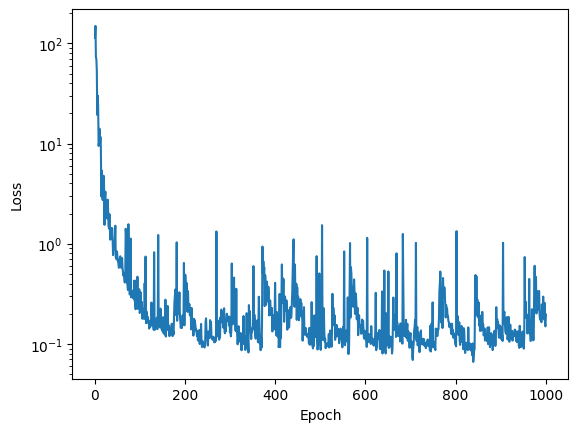

In [ ]:
epochs = [i for i in range(1,len(losses)+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
min(losses), min(errors)

(0.06618473, 0.11417871)

In [ ]:
losses.index(min(losses)), errors.index(min(errors))

(838, 826)

In [ ]:
u2model = u_model()
u2model.set_weights(uweights[826])
s2model = s_model()
s2model.set_weights(sweights[826])
c2model = c_model()
c2model.set_weights(cweights[826])

In [ ]:
u2model.save('/content/drive/MyDrive/Shivprasad/UMCT10b')
s2model.save('/content/drive/MyDrive/Shivprasad/SMCT10b')
c2model.save('/content/drive/MyDrive/Shivprasad/CMCT10b')

Text(0, 0.5, 'u (Temperature)')

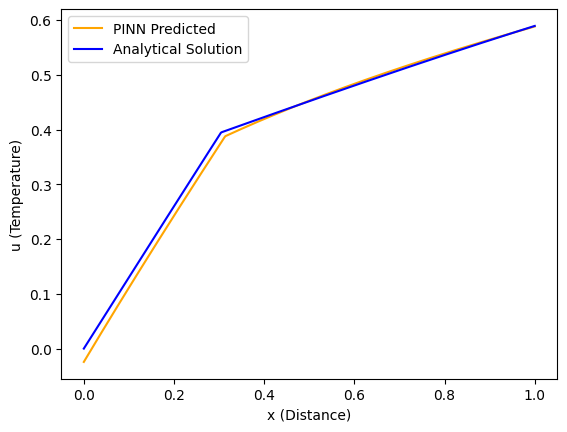

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u2model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = s2model(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(0.31351042, 0.3044444)

Text(0, 0.5, 'c (Concentration)')

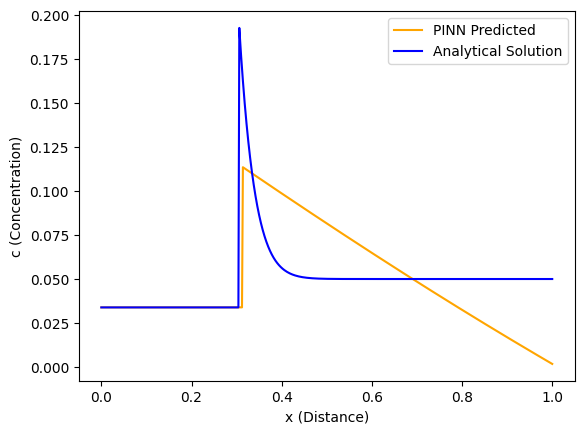

In [ ]:
c2p = c2model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'u (Temperature)')

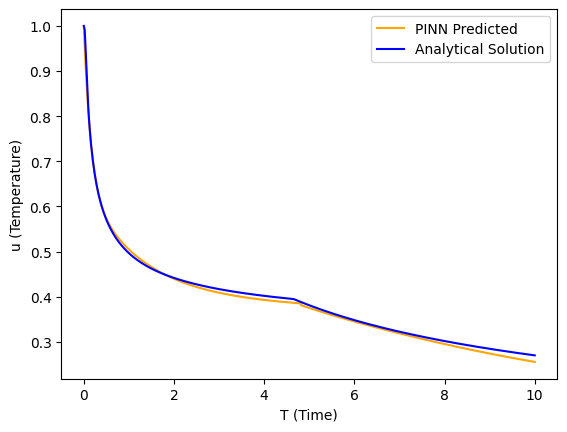

In [ ]:
N = 500
tspace = np.expand_dims(np.linspace(tmin, tmax, N+1),axis=1)
xspace = np.ones_like(tspace)*0.5
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u2model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = s2model(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(T,U,color='orange')
plt.plot(T,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('T (Time)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

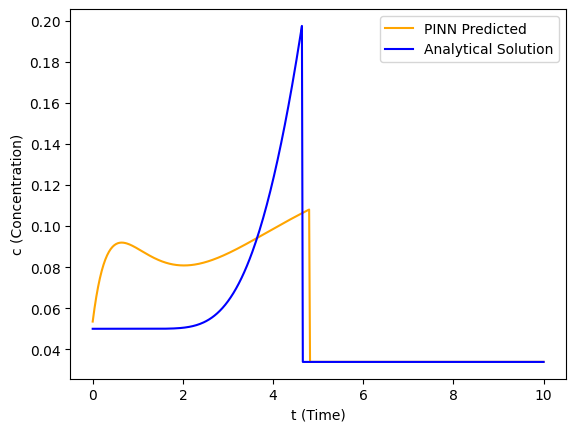

In [ ]:
c2p = c2model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

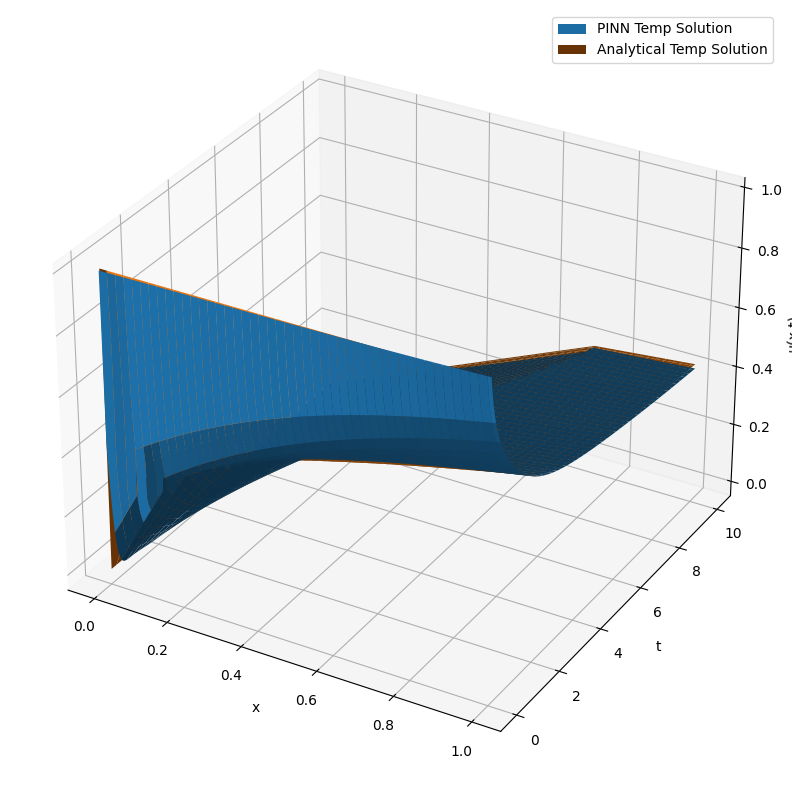

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = u2model(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
s_pred = s2model(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, U, label = 'PINN Temp Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, UT, label = 'Analytical Temp Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

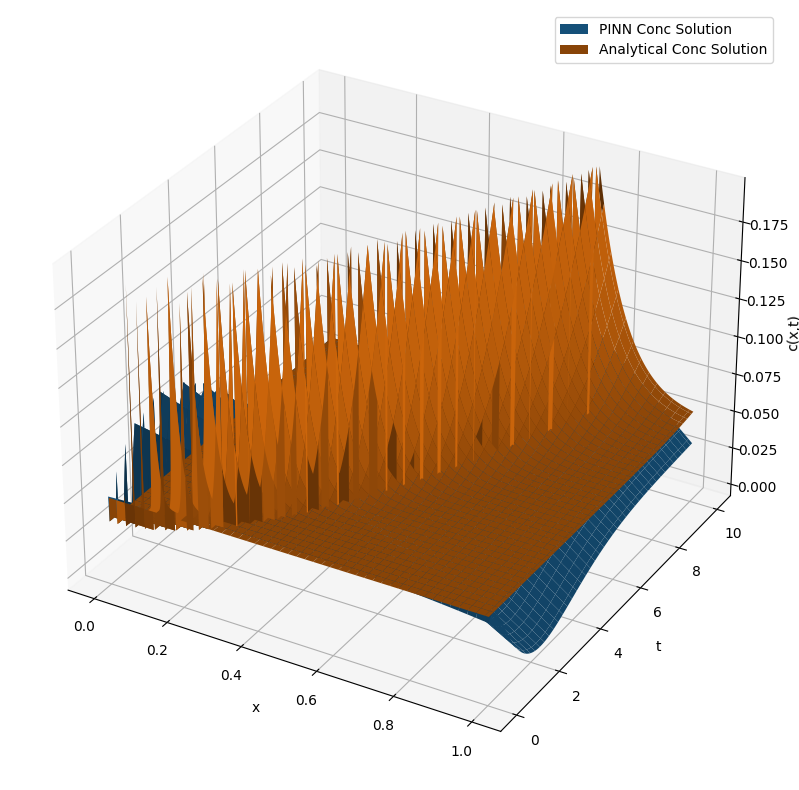

In [ ]:
C1 = 0.03390457
c_pred = c2model(input)
C1p = tf.ones_like(x_inp,dtype=DTYPE)*C1
cp = tf.where(tf.math.greater(s_pred,x_inp), C1p, c_pred)
C = cp.numpy().reshape(N+1,N+1)
c_true = c_anal(t,x)
CT = c_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, C, label = 'PINN Conc Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, CT, label = 'Analytical Conc Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('c(x,t)')
ax.legend()

Text(0.5, 1.0, 'Predicted vs Actual Movement of Interface')

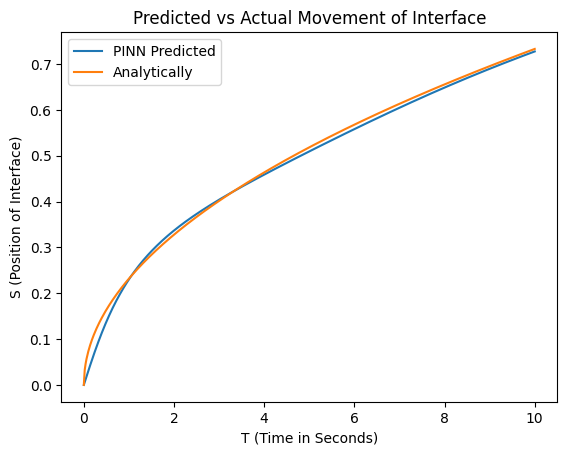

In [ ]:
t_values = tf.cast(tspace,DTYPE)
s_values = s2model(t_values)
s_exact = s_anal(t_values)
plt.plot(t_values,s_values)
plt.plot(t_values,s_exact)
plt.legend(['PINN Predicted','Analytically'])
plt.xlabel('T (Time in Seconds)')
plt.ylabel('S (Position of Interface)')
plt.title('Predicted vs Actual Movement of Interface')

In [ ]:
def loss_fxn_2(umodel, smodel, c1, cmodel, mea, um, cm, coll): # compute Loss given model and data

  tc = coll[:,0:1]
  psb = smodel(tc) # Predicted Interface positions
  pub = umodel(tf.concat([tc, psb], axis=1)) # Interface Temperature prediction
  pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
  pcb = cmodel(tf.concat([tc, psb], axis=1)) # Interface Concentration prediction
  xi = tf.zeros(shape=tf.shape(tc), dtype=DTYPE)
  pu0b = umodel(tf.concat([tc, xi], axis=1))[:, 0:1] # Left boundary temperature prediction
  Lb1 = tf.reduce_mean(tf.square(pu0b))
  Lb2 = tf.reduce_mean(tf.square(pu1b-pu2b))
  Lb3 = tf.reduce_mean(tf.square(pcb-C_(pu1b)))

  pc1 = tf.ones_like(tc,dtype=DTYPE)*c1
  Ls = tf.reduce_mean(tf.square(pc1-(k0*pcb)))

  init = tf.constant(0,shape=(1,1))
  init2 = tf.concat([xi, coll[:,1:2]], axis=1)
  pu2i = umodel(init2)[:, 1:2] # predicted initial temp of liquid
  pc2i = cmodel(init2) # predicted initial conc of liquid
  Li1 = tf.squeeze(tf.square(smodel(init)))
  Li2 = tf.reduce_mean(tf.square(pc2i-C0))
  Li3 = tf.reduce_mean(tf.square(pu2i-a))

  pum = umodel(mea) # Temperature prediction on measurement data
  pu1m, pu2m = pum[:, 0:1], pum[:, 1:2]
  pc2m = cmodel(mea) # Liquid Concentration prediction on measurement data
  pc1m = tf.ones_like(pc2m, dtype=DTYPE)*c1 # Solid Concentration prediction on measurement data
  psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
  pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
  pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
  Lm1 = tf.reduce_mean(tf.square(um - pum))
  Lm2 = tf.reduce_mean(tf.square(cm - pcm))
  Lm3 = tf.reduce_mean(tf.square(sm2 - psm))

  f_1, f_2, f_3, f_4, f_5 = get_f(umodel, smodel, cmodel, coll) # calculate f values given models and collocation data
  Lc1 = tf.reduce_mean(tf.square(f_1))
  Lc2 = tf.reduce_mean(tf.square(f_2))
  Lc3 = tf.reduce_mean(tf.square(f_3))
  Lc4 = tf.reduce_mean(tf.square(f_4))
  Lc5 = tf.reduce_mean(tf.square(f_5))

  losses = [Lb1*256,Lb2*256,Lb3*256,Ls*256,Li1*25600,Li2*100,Li3*100,Lc1,Lc2,Lc3,Lc4,Lc5,Lm1*25.6,Lm2*25.6,Lm3*25.6]

  return losses

In [ ]:
def L_and_grad_Lw_2(umodel, smodel, c1, cmodel, mea, um, cm, coll, lamb1, lamb2): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    losses = loss_fxn_2(umodel, smodel, c1, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights)
    Lur = losses[7] + losses[8]
    Lcr = losses[9] + losses[3]
    Lud = losses[-3]
    Lcd = losses[-2]
    loss = sum(losses[0:12]) + lamb1*Lud + lamb2*Lcd
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gur = tape.gradient(Lur, umodel.trainable_variables)
  gud = tape.gradient(Lud, umodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return losses, gu, gs, gc, gur, gud, gcr, gcd

In [ ]:
Nc = 10000 # No of collocation points
umodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/UMCT10b') # initialise the Temp NN model
smodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/SMCT10b') # initialise the Intf NN model
cmodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/CMCT10b') # initialise the Conc NN model
c1 = 0.03390457
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) # Adam Optimiser

In [ ]:
@tf.function
def train_step_2(coll,lamb1,lamb2):
  # compute loss and its gradient wrt model parameters
  losses, gu, gs, gc, gur, gud, gcr, gcd = L_and_grad_Lw_2(umodel, smodel, c1, cmodel, meas, um, cm, coll, lamb1, lamb2)
  fgud = tf.concat([tf.reshape(g,[-1]) for g in gud if g is not None],axis=-1)
  denom1 = tf.reduce_mean(tf.math.abs(fgud))
  fgur = tf.concat([tf.reshape(g,[-1]) for g in gur if g is not None],axis=-1)
  numer1 = tf.reduce_max(tf.math.abs(fgur))
  new_lamb1 = numer1/denom1
  new_lamb1 = 0.1*new_lamb1 + 0.9*lamb1
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  return losses, new_lamb1, new_lamb2

### Training 1 with adpatively weighted loss function

In [ ]:
uweights, cweights = [], []
from time import time
N = 1000 # no of epochs or training iterations
losses = []
t0 = time()
lamb1, lamb2 = 1000, 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step_2(coll,lamb1,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps)
  losses.append(loss.numpy())
  uweights.append(umodel.get_weights())
  cweights.append(cmodel.get_weights())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.56991065, 0.63547283, 2.5454848, 0.9640992, 6.1087034e-05, 0.000723617, 0.0021506897, 0.04957147, 0.10643064, 0.00070618436, 0.18577655, 6.542194e-05, 0.011589758, 0.02564066, 0.0029518956]
[0.2843537, 0.5735826, 1.589054, 0.9552244, 6.1087034e-05, 0.015827348, 0.058486324, 0.082311176, 0.14576839, 0.0018617319, 0.18787503, 4.8563386e-05, 0.00756585, 0.014404911, 0.0029518956]
[0.1574711, 0.60610193, 0.9227575, 0.9475631, 6.1087034e-05, 0.015720436, 0.058734674, 0.15383843, 0.15843184, 0.009940862, 0.15562864, 6.453198e-05, 0.0064490805, 0.011917478, 0.0029518956]
[0.10086432, 0.6493899, 0.81952304, 0.94564503, 6.1087034e-05, 0.021886328, 0.06442668, 0.2391149, 0.19955027, 0.023422353, 0.13252641, 6.825546e-05, 0.0057071736, 0.011283354, 0.0029518956]
[0.05925591, 0.5652005, 0.7125423, 0.9432453, 6.1087034e-05, 0.025103774, 0.06816922, 0.28916642, 0.2366334, 0.044670977, 0.123907275, 7.263513e-05, 0.005149377, 0.010854401, 0.0029518956]
[0.033047337, 0.44974795, 0.63712573, 0.942180

Text(0, 0.5, 'Loss')

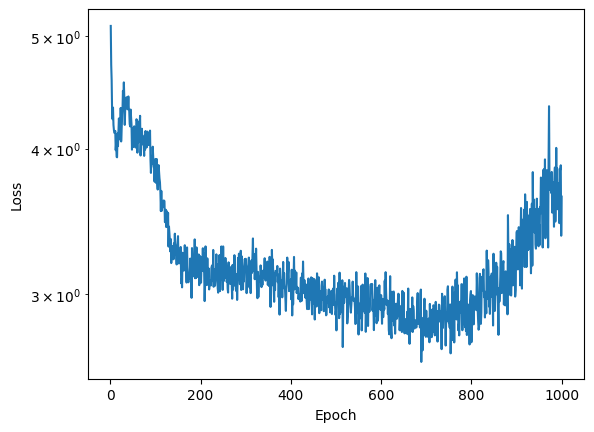

In [ ]:
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

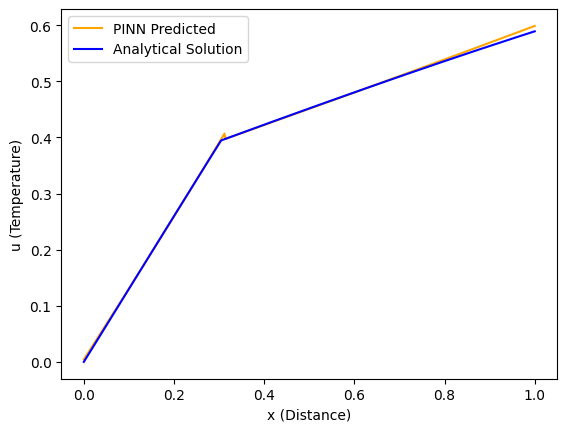

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

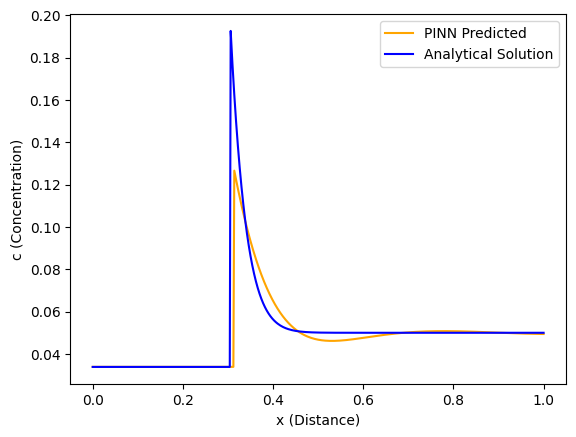

In [ ]:
c2p = cmodel(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'u (Temperature)')

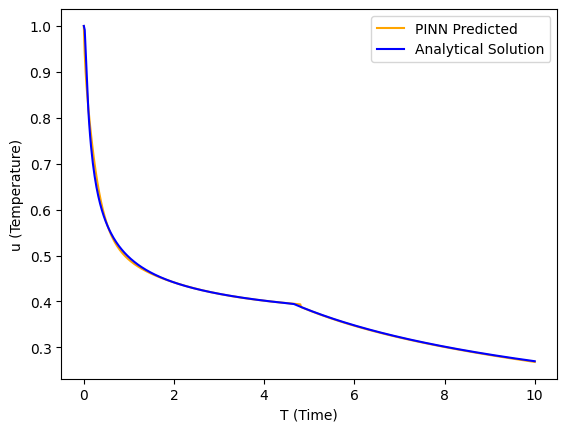

In [ ]:
N = 500
tspace = np.expand_dims(np.linspace(tmin, tmax, N+1),axis=1)
xspace = np.ones_like(tspace)*0.5
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = umodel(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(T,U,color='orange')
plt.plot(T,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('T (Time)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

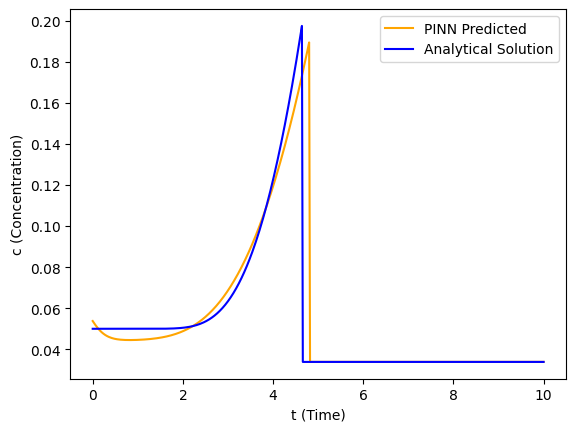

In [ ]:
c2p = cmodel(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

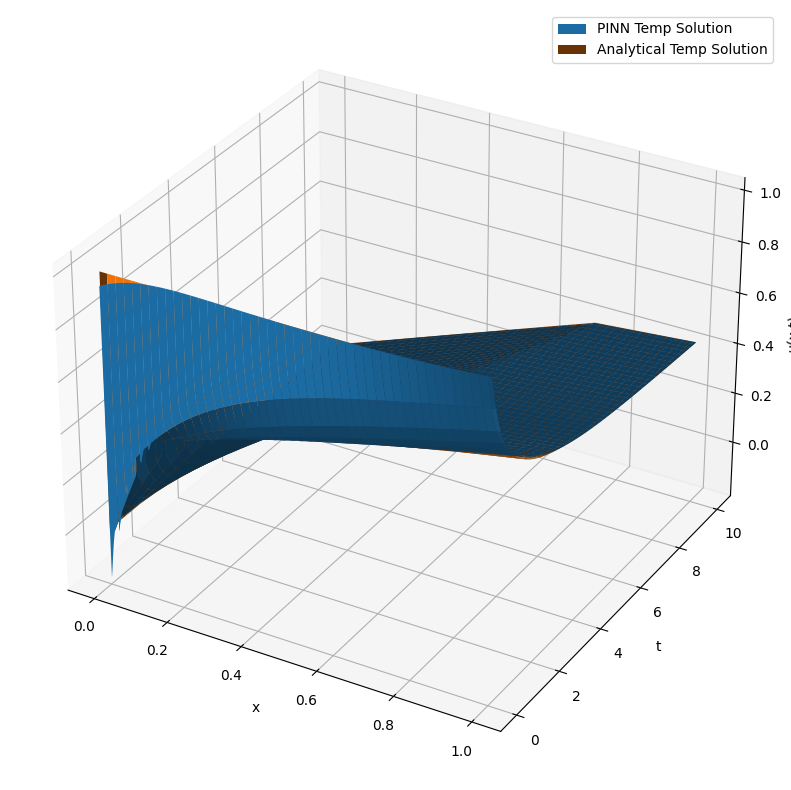

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = umodel(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
s_pred = smodel(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
m1 = ax.plot_surface(X, T, U, label = 'PINN Temp Solution')
m1._facecolors2d = m1._facecolor3d
m1._edgecolors2d = m1._edgecolor3d
m2 = ax.plot_surface(X, T, UT, label = 'Analytical Temp Solution')
m2._facecolors2d = m2._facecolor3d
m2._edgecolors2d = m2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

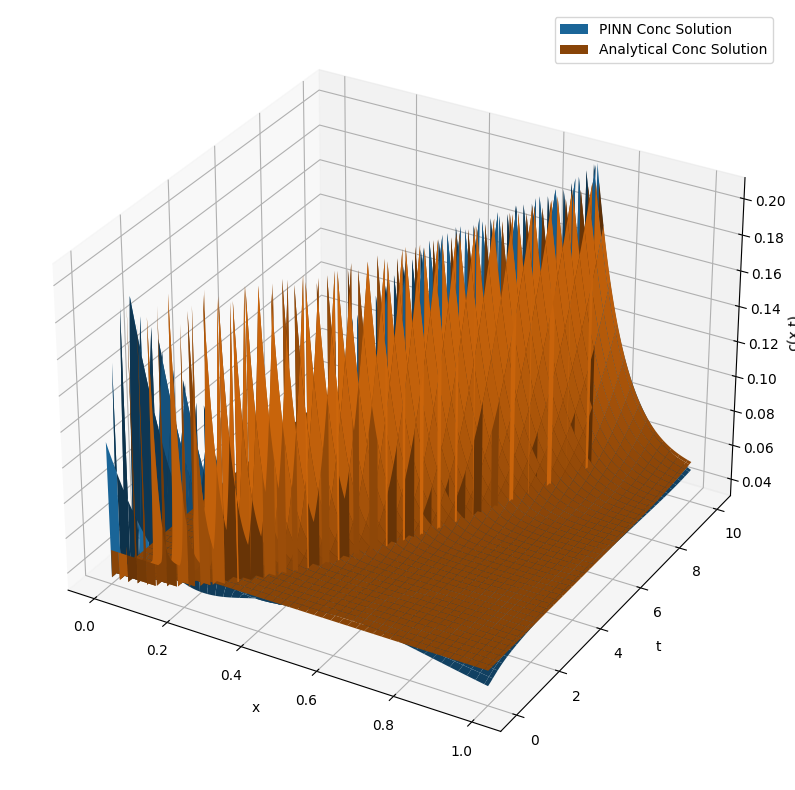

In [ ]:
C1 = 0.03390457
c_pred = cmodel(input)
C1p = tf.ones_like(x_inp,dtype=DTYPE)*C1
cp = tf.where(tf.math.greater(s_pred,x_inp), C1p, c_pred)
C = cp.numpy().reshape(N+1,N+1)
c_true = c_anal(t,x)
CT = c_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
m1 = ax.plot_surface(X, T, C, label = 'PINN Conc Solution')
m1._facecolors2d = m1._facecolor3d
m1._edgecolors2d = m1._edgecolor3d
m2 = ax.plot_surface(X, T, CT, label = 'Analytical Conc Solution')
m2._facecolors2d = m2._facecolor3d
m2._edgecolors2d = m2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('c(x,t)')
ax.legend()

In [ ]:
umodel.save('/content/drive/MyDrive/Shivprasad/U10b')
cmodel.save('/content/drive/MyDrive/Shivprasad/C10b')

In [ ]:
losses.index(min(losses))

688

In [ ]:
u2model = u_model()
u2model.set_weights(uweights[688])
c2model = c_model()
c2model.set_weights(cweights[688])

Text(0, 0.5, 'u (Temperature)')

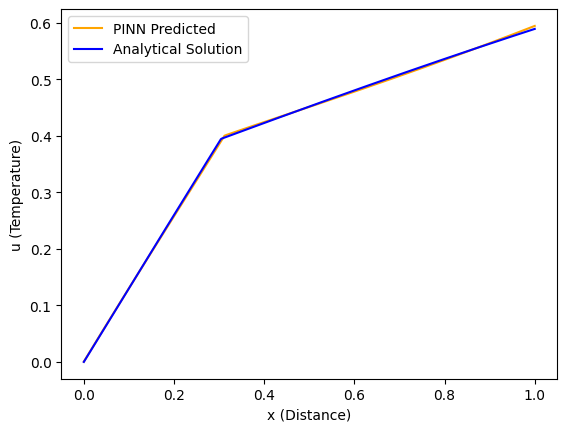

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u2model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

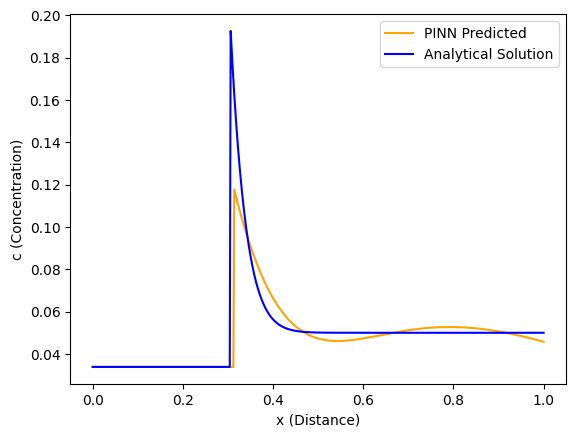

In [ ]:
c2p = c2model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'u (Temperature)')

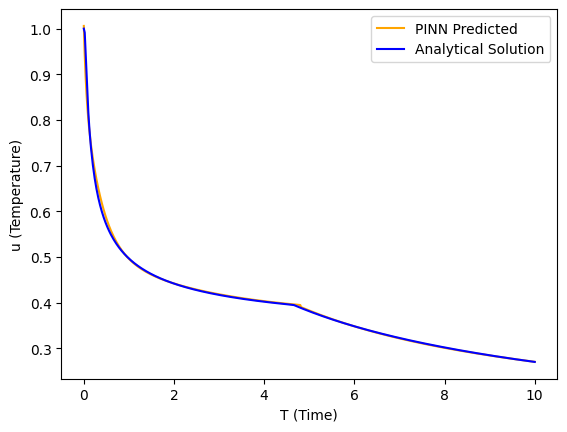

In [ ]:
N = 500
tspace = np.expand_dims(np.linspace(tmin, tmax, N+1),axis=1)
xspace = np.ones_like(tspace)*0.5
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u2model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(T,U,color='orange')
plt.plot(T,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('T (Time)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

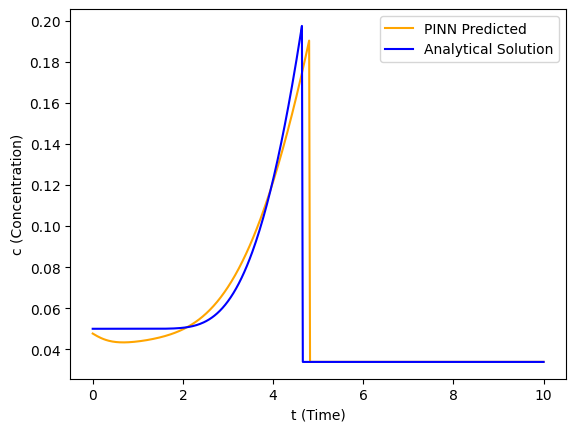

In [ ]:
c2p = c2model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

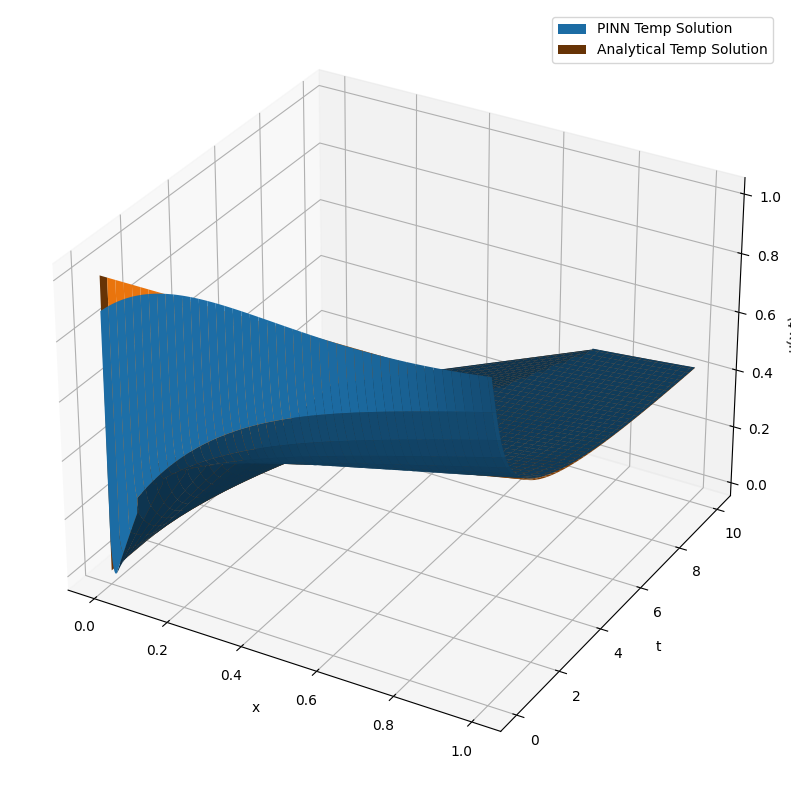

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = u2model(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
s_pred = smodel(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
m1 = ax.plot_surface(X, T, U, label = 'PINN Temp Solution')
m1._facecolors2d = m1._facecolor3d
m1._edgecolors2d = m1._edgecolor3d
m2 = ax.plot_surface(X, T, UT, label = 'Analytical Temp Solution')
m2._facecolors2d = m2._facecolor3d
m2._edgecolors2d = m2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

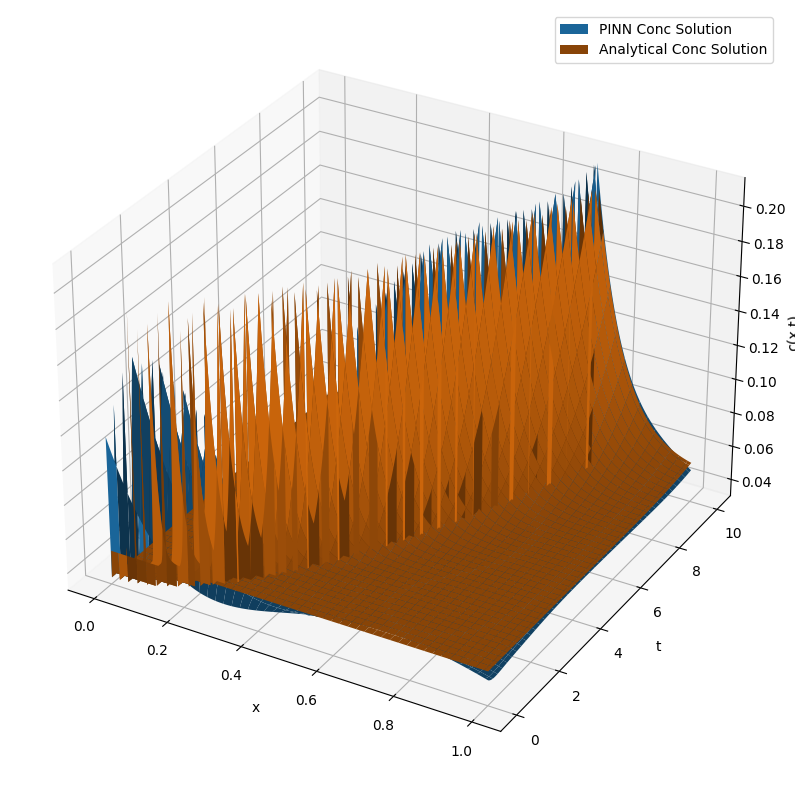

In [ ]:
C1 = 0.03390457
c_pred = c2model(input)
C1p = tf.ones_like(x_inp,dtype=DTYPE)*C1
cp = tf.where(tf.math.greater(s_pred,x_inp), C1p, c_pred)
C = cp.numpy().reshape(N+1,N+1)
c_true = c_anal(t,x)
CT = c_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
m1 = ax.plot_surface(X, T, C, label = 'PINN Conc Solution')
m1._facecolors2d = m1._facecolor3d
m1._edgecolors2d = m1._edgecolor3d
m2 = ax.plot_surface(X, T, CT, label = 'Analytical Conc Solution')
m2._facecolors2d = m2._facecolor3d
m2._edgecolors2d = m2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('c(x,t)')
ax.legend()

In [ ]:
u2model.save('/content/drive/MyDrive/Shivprasad/U210b')
c2model.save('/content/drive/MyDrive/Shivprasad/C210b')

In [ ]:
def L_and_grad_Lw_3(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    loss, error = loss_fxn(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e) # loss as a function of model (& hence weights)
  gu = tape.gradient(loss, umodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  del tape
  return loss, error, gu, gc

In [ ]:
Nt, Nx = 100, 256 # No of t and x points sampled
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

In [ ]:
@tf.function

def train_step_3(xc, times, e):

  # compute loss and its gradient wrt model parameters
  loss, error, gu, gc = L_and_grad_Lw_3(umodel, smodel, c1, cmodel, meas, um, cm, xc, times, e)

  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, umodel.trainable_variables))
  optim.apply_gradients(zip(gc, cmodel.trainable_variables))

  return loss, error

### Causal Training 2

In [ ]:
u2weights = []
c2weights = []

from time import time
N = 150 # no of epochs or training iterations
losses2 = []
errors2 = []
t0 = time()
epsilons = [0.01]

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        l, e = train_step_3(xc, times, e)
        loss = l.numpy()
        error = e.numpy()
        losses2.append(loss)
        errors2.append(error)
        u2weights.append(umodel.get_weights())
        c2weights.append(cmodel.get_weights())
        if i%5==0:
            print('   Epoch = '+str(i)+' --> Loss = '+str(loss)+' and Error = '+str(error))

print('Computation Time = {} minutes'.format((time()-t0)/60))

Looping for epsilon = 0.01 ...
   Epoch = 5 --> Loss = 0.17138775 and Error = 1.1703991
   Epoch = 10 --> Loss = 0.29267764 and Error = 1.4528909
   Epoch = 15 --> Loss = 0.12480072 and Error = 1.2600048
   Epoch = 20 --> Loss = 0.1778679 and Error = 0.632779
   Epoch = 25 --> Loss = 0.08631015 and Error = 0.60788274
   Epoch = 30 --> Loss = 0.06583254 and Error = 0.6255434
   Epoch = 35 --> Loss = 0.0676702 and Error = 0.2067765
   Epoch = 40 --> Loss = 0.04717096 and Error = 1.3812402
   Epoch = 45 --> Loss = 0.22968629 and Error = 1.3803746
   Epoch = 50 --> Loss = 0.08350616 and Error = 0.25583005
   Epoch = 55 --> Loss = 0.097389154 and Error = 2.206818
   Epoch = 60 --> Loss = 0.06507314 and Error = 1.5440881
   Epoch = 65 --> Loss = 0.26995274 and Error = 1.8851892
   Epoch = 70 --> Loss = 0.0511677 and Error = 0.53797835
   Epoch = 75 --> Loss = 0.05146268 and Error = 0.8591688
   Epoch = 80 --> Loss = 0.038714536 and Error = 0.94885665
   Epoch = 85 --> Loss = 0.03810609 and E

In [ ]:
min(losses2), min(errors2)

(0.028059872, 0.15314244)

In [ ]:
losses2.index(min(losses2)), errors2.index(min(errors2))

(78, 76)

In [ ]:
u3model = u_model()
u3model.set_weights(u2weights[76])
c3model = c_model()
c3model.set_weights(c2weights[76])

Text(0, 0.5, 'u (Temperature)')

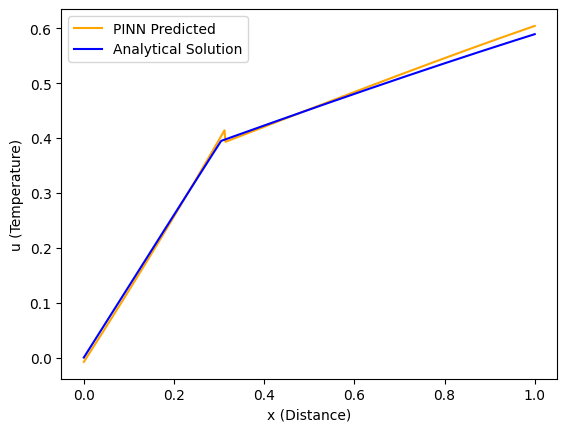

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u3model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

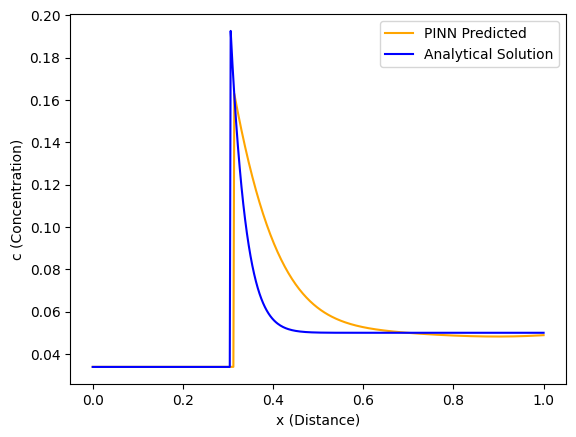

In [ ]:
c2p = c3model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'u (Temperature)')

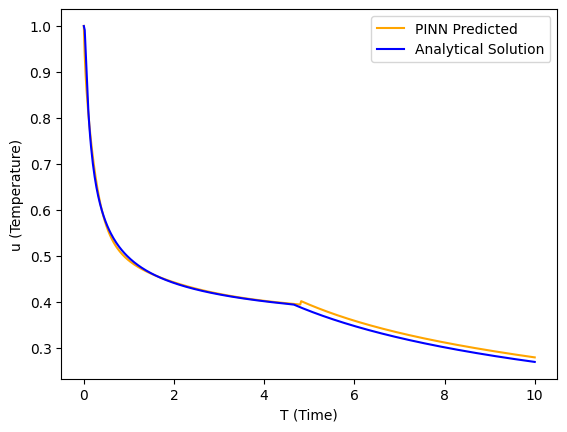

In [ ]:
N = 500
tspace = np.expand_dims(np.linspace(tmin, tmax, N+1),axis=1)
xspace = np.ones_like(tspace)*0.5
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u3model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(T,U,color='orange')
plt.plot(T,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('T (Time)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

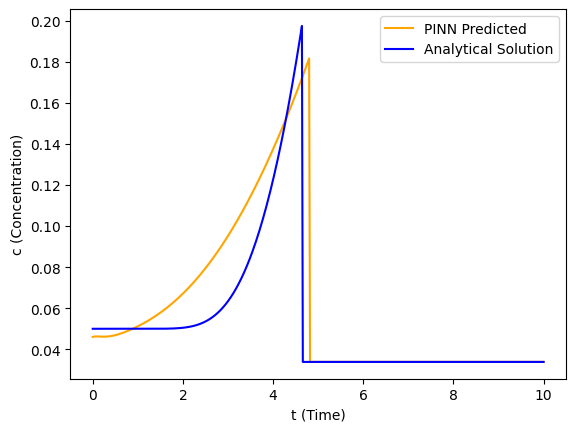

In [ ]:
c2p = c3model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

In [ ]:
def L_and_grad_Lw_2(umodel, smodel, c1, cmodel, mea, um, cm, coll, lamb1, lamb2): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    losses = loss_fxn_2(umodel, smodel, c1, cmodel, mea, um, cm, coll) # loss as a function of model (& hence weights)
    Lur = losses[7] + losses[8]
    Lcr = losses[9] + losses[3]
    Lud = losses[-3]
    Lcd = losses[-2]
    loss = sum(losses[0:12]) + lamb1*Lud + lamb2*Lcd
  gu = tape.gradient(loss, umodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  gur = tape.gradient(Lur, umodel.trainable_variables)
  gud = tape.gradient(Lud, umodel.trainable_variables)
  gcr = tape.gradient(Lcr, cmodel.trainable_variables)
  gcd = tape.gradient(Lcd, cmodel.trainable_variables)
  del tape
  return losses, gu, gc, gur, gud, gcr, gcd

In [ ]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) # Adam Optimiser

In [ ]:
@tf.function
def train_step_2(coll,lamb1,lamb2):
  # compute loss and its gradient wrt model parameters
  losses, gu, gc, gur, gud, gcr, gcd = L_and_grad_Lw_2(u3model, smodel, c1, c3model, meas, um, cm, coll, lamb1, lamb2)
  fgud = tf.concat([tf.reshape(g,[-1]) for g in gud if g is not None],axis=-1)
  denom1 = tf.reduce_mean(tf.math.abs(fgud))
  fgur = tf.concat([tf.reshape(g,[-1]) for g in gur if g is not None],axis=-1)
  numer1 = tf.reduce_max(tf.math.abs(fgur))
  new_lamb1 = numer1/denom1
  new_lamb1 = 0.1*new_lamb1 + 0.9*lamb1
  fgcd = tf.concat([tf.reshape(g,[-1]) for g in gcd if g is not None],axis=-1)
  denom2 = tf.reduce_mean(tf.math.abs(fgcd))
  fgcr = tf.concat([tf.reshape(g,[-1]) for g in gcr if g is not None],axis=-1)
  numer2 = tf.reduce_max(tf.math.abs(fgcr))
  new_lamb2 = numer2/denom2
  new_lamb2 = 0.1*new_lamb2 + 0.9*lamb2
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gu, u3model.trainable_variables))
  optim.apply_gradients(zip(gc, c3model.trainable_variables))
  return losses, new_lamb1, new_lamb2

### Training 2 with adpatively weighted loss function

In [ ]:
u3weights, c3weights = [], []
from time import time
N = 1000 # no of epochs or training iterations
losses3 = []
t0 = time()
lamb1, lamb2 = 1000, 1000
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss_comps, lamb1, lamb2 = train_step_2(coll,lamb1,lamb2)
  if i%100 == 0 or i == 1:
      print([num.numpy() for num in loss_comps]) # recording loss components every 100 epochs
  loss = sum(loss_comps)
  losses3.append(loss.numpy())
  u3weights.append(u3model.get_weights())
  c3weights.append(c3model.get_weights())
print('Computation Time = {} minutes'.format((time()-t0)/60))

[0.056557667, 0.37918392, 0.18229294, 0.93952775, 6.1087034e-05, 0.0018217827, 8.403805e-05, 0.30599838, 0.39192614, 0.03002677, 0.13234332, 0.0001448723, 0.003186614, 0.014496732, 0.0029518956]
[0.055716883, 0.55175126, 0.43626943, 0.93941796, 6.1087034e-05, 0.010756571, 0.0059191464, 0.57190114, 0.7248766, 0.0721824, 0.1317149, 0.000101712954, 0.0010118443, 0.010106639, 0.0029518956]
[0.079904355, 0.52960783, 0.3502995, 0.9388123, 6.1087034e-05, 0.007660163, 0.0032715434, 0.7414901, 0.6266761, 0.08107599, 0.12988675, 0.00011527165, 0.0007209287, 0.009890853, 0.0029518956]
[0.08126484, 0.45347744, 0.26800928, 0.93725294, 6.1087034e-05, 0.004208684, 0.0031830336, 0.62087137, 0.59914863, 0.09184064, 0.12574589, 0.00013135467, 0.0005768234, 0.0097257905, 0.0029518956]
[0.08562097, 0.47971344, 0.2320964, 0.93737686, 6.1087034e-05, 0.003032057, 0.0077945683, 0.96544737, 0.91723204, 0.10435308, 0.124433205, 0.00013616473, 0.0014776433, 0.009617712, 0.0029518956]
[0.05025741, 0.3324337, 0.21

Text(0, 0.5, 'Loss')

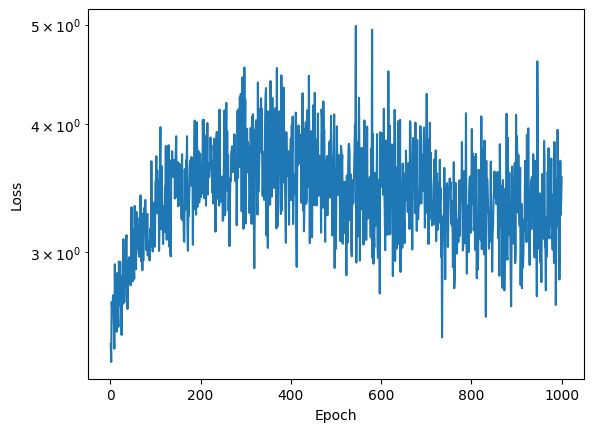

In [ ]:
epochs = [i for i in range(1,N+1)]
plt.yscale('log')
plt.plot(epochs, losses3)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'u (Temperature)')

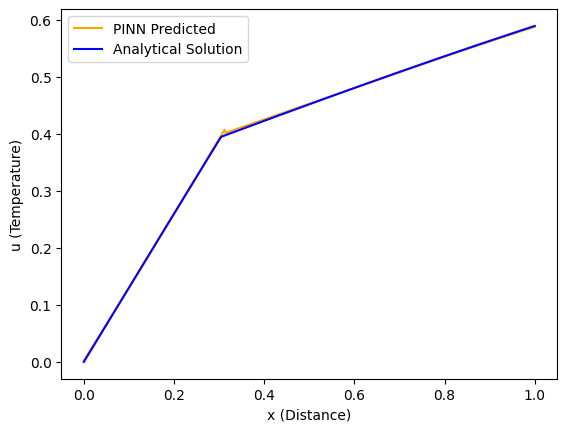

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u3model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

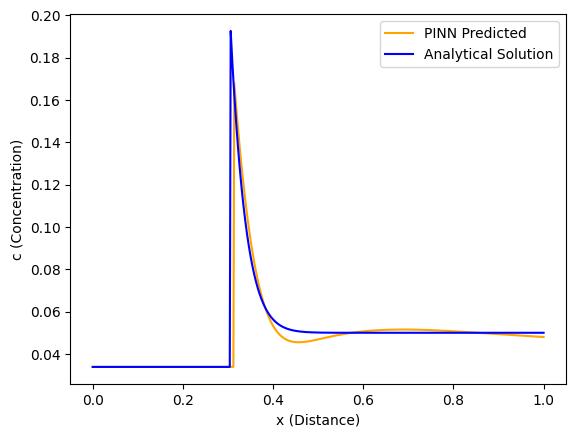

In [ ]:
c2p = c3model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'u (Temperature)')

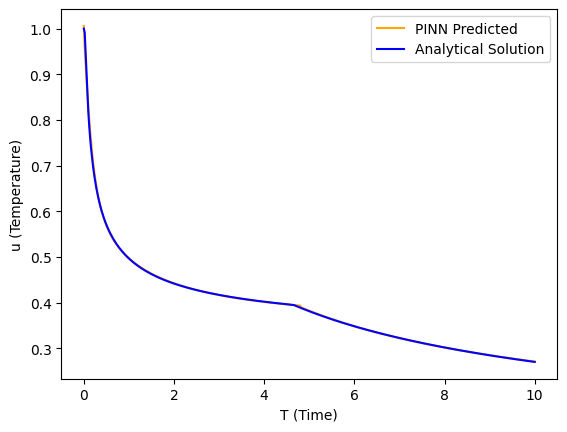

In [ ]:
N = 500
tspace = np.expand_dims(np.linspace(tmin, tmax, N+1),axis=1)
xspace = np.ones_like(tspace)*0.5
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u3model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = smodel(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(T,U,color='orange')
plt.plot(T,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('T (Time)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

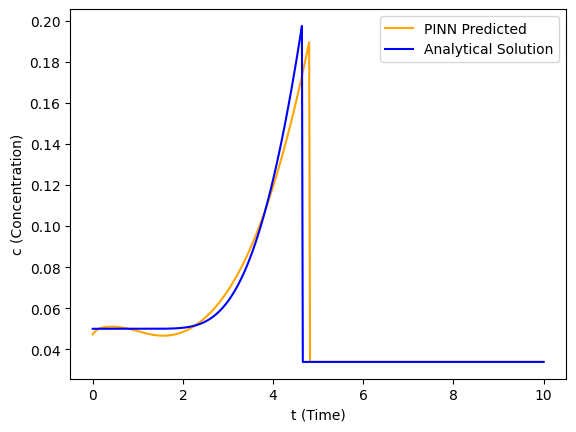

In [ ]:
c2p = c3model(tf.concat([T, X], axis=1))
c1p = tf.ones_like(c2p,dtype=DTYPE)*c1
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

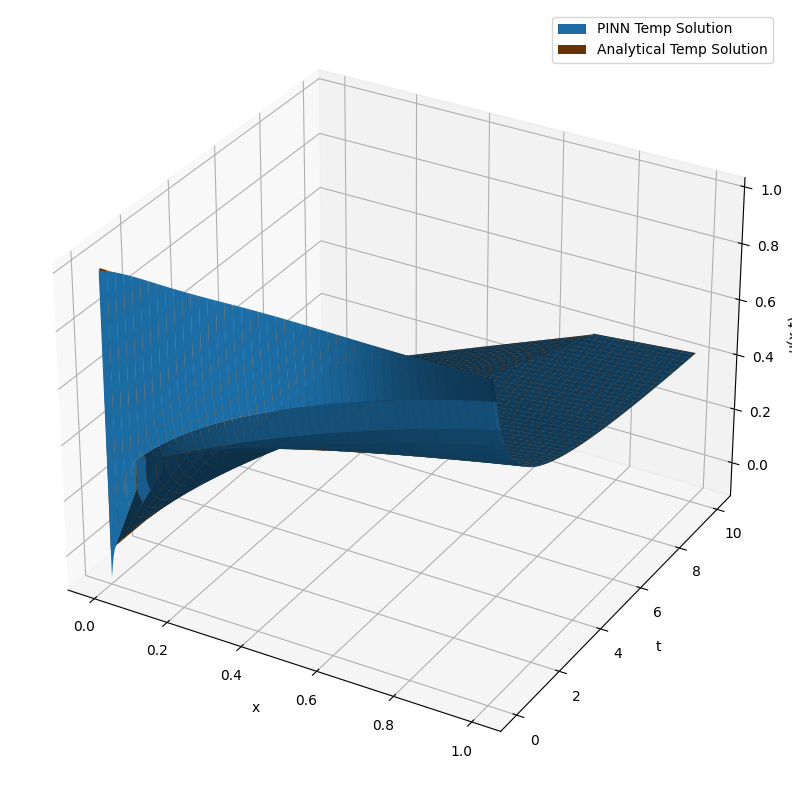

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = u3model(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
s_pred = smodel(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
m1 = ax.plot_surface(X, T, U, label = 'PINN Temp Solution')
m1._facecolors2d = m1._facecolor3d
m1._edgecolors2d = m1._edgecolor3d
m2 = ax.plot_surface(X, T, UT, label = 'Analytical Temp Solution')
m2._facecolors2d = m2._facecolor3d
m2._edgecolors2d = m2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

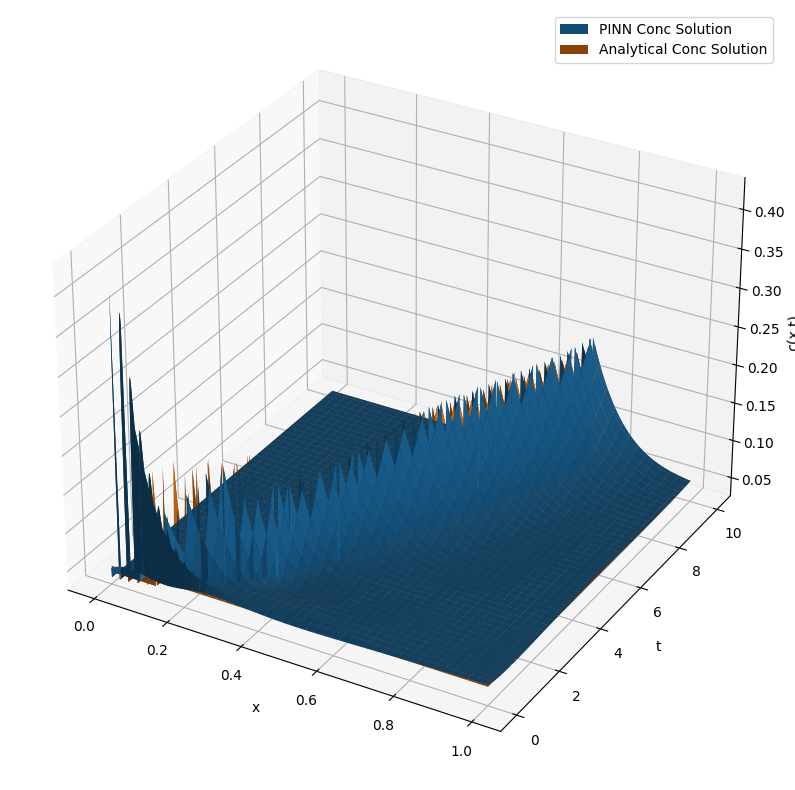

In [ ]:
C1 = 0.03390457
c_pred = c3model(input)
C1p = tf.ones_like(x_inp,dtype=DTYPE)*C1
cp = tf.where(tf.math.greater(s_pred,x_inp), C1p, c_pred)
C = cp.numpy().reshape(N+1,N+1)
c_true = c_anal(t,x)
CT = c_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
m1 = ax.plot_surface(X, T, C, label = 'PINN Conc Solution')
m1._facecolors2d = m1._facecolor3d
m1._edgecolors2d = m1._edgecolor3d
m2 = ax.plot_surface(X, T, CT, label = 'Analytical Conc Solution')
m2._facecolors2d = m2._facecolor3d
m2._edgecolors2d = m2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('c(x,t)')
ax.legend()

In [ ]:
u3model.save('/content/drive/MyDrive/Shivprasad/U310b')
c3model.save('/content/drive/MyDrive/Shivprasad/C310b')

In [ ]:
umodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/U310b') # initialise the Temp NN model
smodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/SMCT10b') # initialise the Intf NN model
cmodel = tf.keras.models.load_model('/content/drive/MyDrive/Shivprasad/C310b') # initialise the Conc NN model

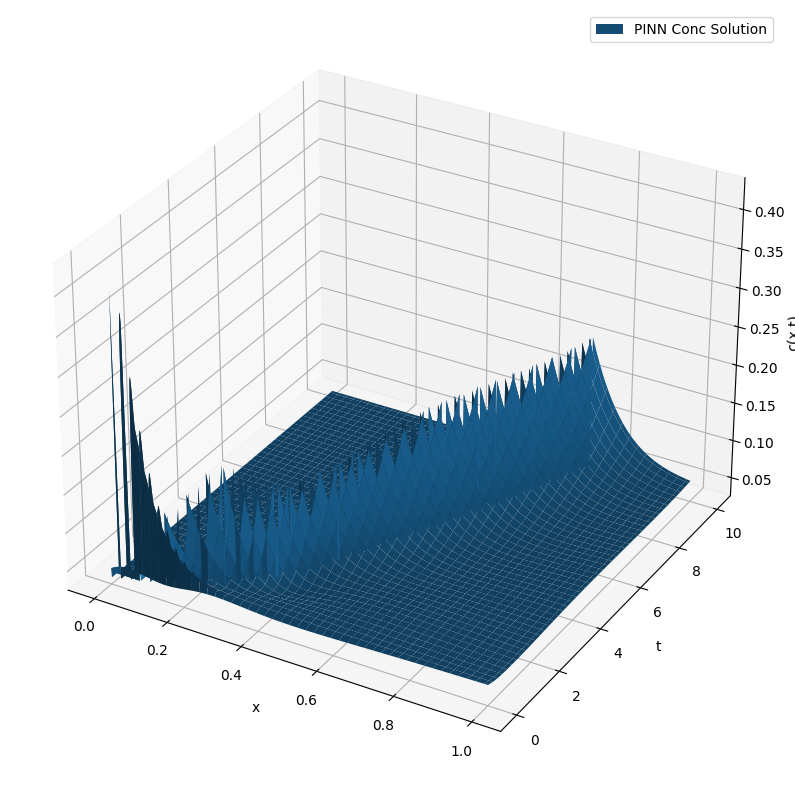

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
s_pred = smodel(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
C1 = 0.03390457
c_pred = cmodel(input)
C1p = tf.ones_like(x_inp,dtype=DTYPE)*C1
cp = tf.where(tf.math.greater(s_pred,x_inp), C1p, c_pred)
C = cp.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
c_true = c_anal(t,x)
CT = c_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
m1 = ax.plot_surface(X, T, C, label = 'PINN Conc Solution')
m1._facecolors2d = m1._facecolor3d
m1._edgecolors2d = m1._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('c(x,t)')
ax.legend()

In [ ]:
u_pred = umodel(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
t_values = tf.cast(tspace,DTYPE)

In [ ]:
np.argwhere(np.isnan(UT))

array([[0, 0]])

In [ ]:
UT[0,0] = 0.0

In [ ]:
UT

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.02419011, 0.01710513, ..., 0.001084  , 0.00108292,
        0.00108183],
       [1.        , 0.0483778 , 0.03420941, ..., 0.00216801, 0.00216583,
        0.00216366],
       ...,
       [1.        , 0.9999996 , 0.99970126, ..., 0.42701495, 0.42689383,
        0.426773  ],
       [1.        , 0.9999996 , 0.9997091 , ..., 0.4272576 , 0.42713624,
        0.42701524],
       [1.        , 0.9999996 , 0.9997168 , ..., 0.4275003 , 0.42737865,
        0.42725736]], dtype=float32)

In [ ]:
U

array([[ 9.9002844e-01, -1.0133095e-01, -8.7375388e-02, ...,
        -2.0960011e-03, -2.0871721e-03, -2.0779707e-03],
       [ 9.9069047e-01, -8.4084973e-02, -7.1732298e-02, ...,
        -9.6765533e-04, -9.5976517e-04, -9.5155835e-04],
       [ 9.9133295e-01, -6.6943601e-02, -5.6185279e-02, ...,
         1.6031787e-04,  1.6716495e-04,  1.7459691e-04],
       ...,
       [ 1.0027397e+00,  1.0086789e+00,  1.0086458e+00, ...,
         4.2617419e-01,  4.2604157e-01,  4.2590928e-01],
       [ 1.0027664e+00,  1.0088096e+00,  1.0088671e+00, ...,
         4.2641041e-01,  4.2627728e-01,  4.2614451e-01],
       [ 1.0027933e+00,  1.0089397e+00,  1.0090874e+00, ...,
         4.2664647e-01,  4.2651299e-01,  4.2637989e-01]], dtype=float32)

In [ ]:
np.linalg.norm(UT.flatten()-U.flatten())/np.linalg.norm(UT.flatten()) # relative L2 error in temperature

0.012399958

In [ ]:
np.argwhere(np.isnan(CT))

array([[0, 0]])

In [ ]:
CT[0,0] = C0
CT

array([[0.05      , 0.03387012, 0.03387012, ..., 0.03387012, 0.03387012,
        0.03387012],
       [0.05      , 0.03387012, 0.03387012, ..., 0.03387012, 0.03387012,
        0.03387012],
       [0.05      , 0.03387012, 0.03387012, ..., 0.03387012, 0.03387012,
        0.03387012],
       ...,
       [0.05      , 0.05      , 0.05      , ..., 0.05365942, 0.05371796,
        0.0537772 ],
       [0.05      , 0.05      , 0.05      , ..., 0.05354478, 0.0536017 ,
        0.0536593 ],
       [0.05      , 0.05      , 0.05      , ..., 0.05343352, 0.05348887,
        0.05354489]], dtype=float32)

In [ ]:
C

array([[0.04677361, 0.03390457, 0.03390457, ..., 0.03390457, 0.03390457,
        0.03390457],
       [0.04738465, 0.03390457, 0.03390457, ..., 0.03390457, 0.03390457,
        0.03390457],
       [0.04796645, 0.03390457, 0.03390457, ..., 0.03390457, 0.03390457,
        0.03390457],
       ...,
       [0.05242466, 0.05221554, 0.05200121, ..., 0.05356884, 0.05362787,
        0.05368788],
       [0.05244079, 0.05222985, 0.05201408, ..., 0.0534446 , 0.05350162,
        0.05355959],
       [0.05245696, 0.05224434, 0.05202702, ..., 0.05332394, 0.05337897,
        0.05343489]], dtype=float32)

In [ ]:
np.linalg.norm(CT.flatten()-C.flatten())/np.linalg.norm(CT.flatten()) # relative L2 error in composition

0.2810655

In [ ]:
s_values = np.squeeze(smodel(t_values))
s_exact = np.squeeze(s_anal(t_values))
s_values.shape,s_exact.shape

((501,), (501,))

In [ ]:
np.linalg.norm(s_exact-s_values)/np.linalg.norm(s_exact) # relative L2 error in interface position

0.021649903

In [ ]:
mean_squared_error(UT.flatten(), U.flatten())

2.3185292e-05

In [ ]:
mean_squared_error(CT.flatten(), C.flatten())

0.00025097196

In [ ]:
mean_squared_error(s_values, s_exact)

0.00012592407